# Monitoring data downloads from colhub portals

In [1]:
import pathlib
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
from IPython.display import Markdown as md

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams.update({'font.size': 22})

In [2]:
# show all rows, all columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [3]:
logsdir = pathlib.Path('../data')

In [4]:
def get_product_type(product):
    """ From a product title, get it's type """
    tipe = 'Unknown'
    try:
        if product[0:2] == 'S1':
            tipe = product.split('_')[2]
        elif product[0:2] == 'S2':
            tipe = product.split('_')[1]
            if not tipe.startswith('M'):
                tipe = 'Unknown'
        elif product[0:2] == 'S3':
            tmp = product.split('_')
            if tmp[1] == 'SL':
                tipe = 'SLSTR_L' + tmp[2]
            elif tmp[1] == 'SR':
                tipe = 'SRAL_L' + tmp[2]
            elif tmp[1] == 'OL':
                tipe = 'OLCI_L' + tmp[2]
            elif tmp[1] == 'SY':
                tipe = 'SYN_L' + tmp[2]
        elif product[0:2] == 'S5':
            tmp = product.split('_')
            if tmp[1] == 'OFFL':
                tipe = 'OFFL_' + tmp[2]
            elif tmp[1] == 'NRTI':
                tipe = 'NRTI_' + tmp[2]
        if 'DTERRENG' in product:
            tipe = tipe + '_DTERRENG'
    except TypeError:
        tipe = 'Unknown'
    return tipe

In [5]:
def get_data_global(file):
    data = pd.read_csv(file, usecols=[0,1,2,4,5], header=None, names=['download_time', 'user', 'product', 'size', 'download_duration']\
                        , parse_dates=['download_time'], index_col='download_time')
    data['satellite'] = data['product'].apply(lambda x: x[0:2])
    data['product_type'] = data['product'].apply(get_product_type)
    return data[data['product_type'] != 'Unknown']
def get_data_aoi(file):
    data = pd.read_csv(file, usecols=[0,1,2,4,5], header=None, names=['download_time', 'user', 'product', 'size', 'download_duration']\
                        , parse_dates=['download_time'], index_col='download_time')
    data['satellite'] = data['product'].apply(lambda x: x[0:2])
    data['product_type'] = data['product'].apply(get_product_type)
    return data[data['product_type'] != 'Unknown']

In this section the perfomance of the FrontEnds is analyzed, for both colhub.met.no and colhub-archive.met.no. The FEs perfomance is translated as user accesibility to the data which is one of the main goals for the project. 

## Portal: colhub.met.no

In [6]:
csvfile = logsdir / 'NBS_frontend-global_outputs.csv'
nbs_global = get_data_global(csvfile)

The first portal to analyze is colhub.met.no. The target of the analysis is to check the amount of data downloaded by users, but also the number of users accessing the datahub. Below the historical amount of data per day is represented.

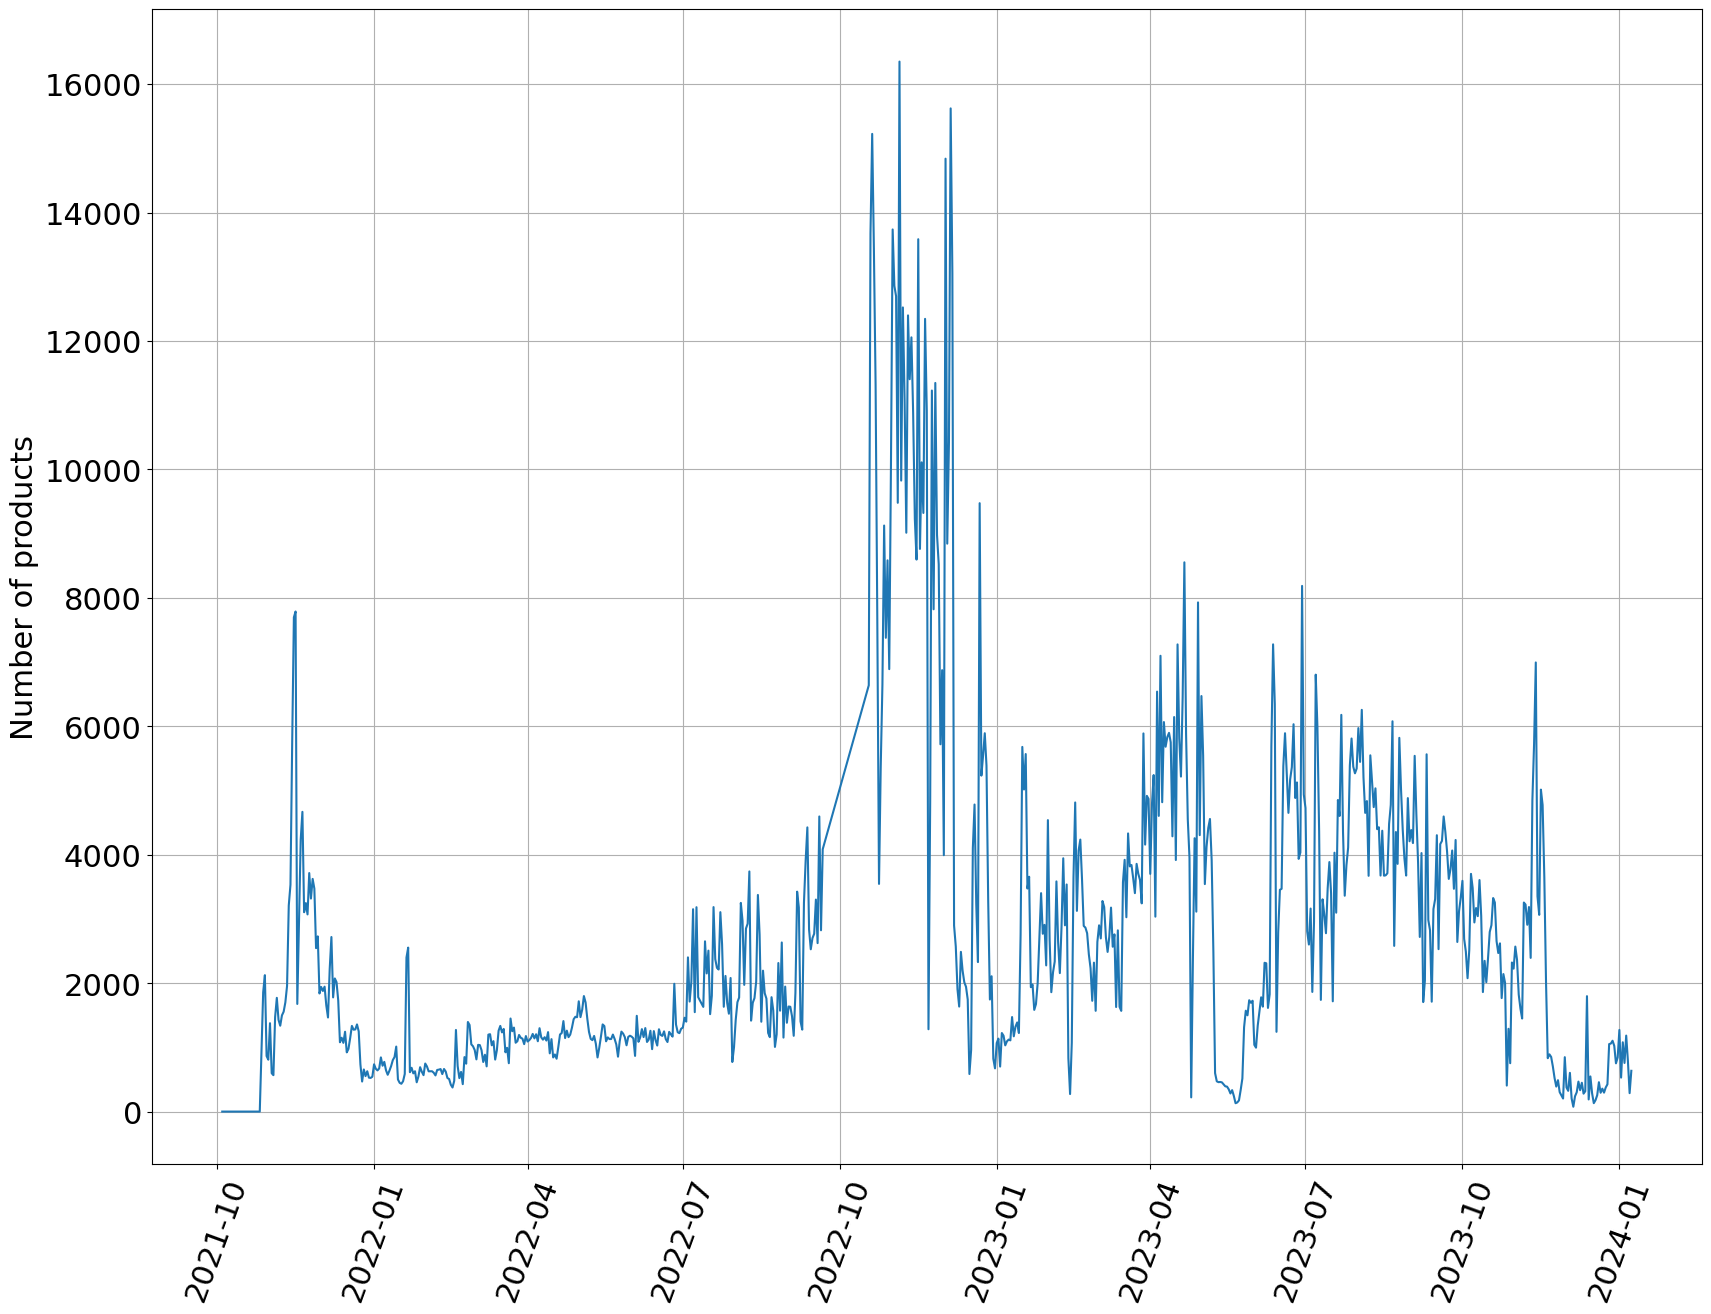

In [7]:
# Number of products downloaded per day
nbs_global.groupby(nbs_global.index.date).count()['product_type'].plot(ylabel='Number of products', rot=70)
plt.grid(True)

The same data is also represented below, with a difference. This time the data is not accounted by numer, but by volume. Although both graphs show similar trends, they are not exactly equal due to the variability in the ratio volume per product. For instance, the seasonality of optical products could have an impact in the total volume of products.

In [15]:
nbs_global.head()

,user,product,size,download_duration,satellite,product_type
download_time,,,,,,
2021-10-04 13:25:34.098,root,S2A_MSIL1C_20211004T113321_N0301_R080_T31VEL_20211004T115457,MSIL1C,434960038,S2,MSIL1C
2021-10-26 13:43:44.491,elodief,S1B_IW_GRDM_1SDV_20211026T063539_20211026T063608_029303_037F3A_0165,GRDM,129852174,S1,GRDM
2021-10-28 08:58:44.980,root,S1A_IW_GRDM_1SDV_20211028T052847_20211028T052917_040315_04C704_48A2,GRDM,130059692,S1,GRDM
2021-10-28 09:37:18.391,elodief,S5P_NRTI_L2__NO2____20211028T081216_20211028T081716_20940_02_020200_20211028T091356,NRTI_L2,2313536,S5,NRTI_L2
2021-10-28 09:37:21.865,elodief,S5P_NRTI_L2__CO_____20211028T083716_20211028T084216_20940_02_020200_20211028T091739,NRTI_L2,16738742,S5,NRTI_L2


In [8]:
# Volume downloaded per day (in Tb)
total = nbs_global.groupby(nbs_global.index.date).sum(numeric_only=True)['size']/1024/1024/1024/1024
total.plot(ylabel='Volume downloaded in Tb', rot=70)
plt.grid(True)

KeyError: 'size'

The table below is also interesting. It shows the amount of products downloaded for each the different Sentinel products. As expected, S1 and S2 are the most used Sentinels. S3 is slightly used, while S5p is not used.

In [ ]:
# Nb of products downloaded per satellite / product
col_table1 = nbs_global.groupby(['satellite', 'product_type']).size()
col_table1

The following table shows the total downloaded volume of data in Tb per month. Here the seasonality of some Sentinel products can affect the final numbers.

In [ ]:
# Monthly total retrieval in Tb
col_table2 = nbs_global.groupby([nbs_global.index.year, nbs_global.index.month]).sum(numeric_only=True)['size']/1024/1024/1024/1024
col_table2

The number of users accessing and using the datahub is also important to be known. The plot below show the number of users per day. Some variability is represented in its numbers. Nevertheless, colhub.met.no is used by 15 to 20 users per day. 

In [ ]:
# Number of unique users that downloaded each day
nbs_global.groupby(nbs_global.index.date).agg({"user": "nunique"}).plot(ylabel='Number of unique users')
plt.grid(True)

## Portal: colhub-archive.met.no

In [ ]:
csvfile = logsdir / 'NBS_frontend-AOI_outputs.csv'
nbs_AOI = get_data_aoi(csvfile)

Similar to colhub.met.no, here it is presented the performance of colhub-archive.met.no. First the number of products downloaded per day. As shown in the plot below, some days the number of products downloaded is null. This is a correct value which is not reflecting the performance of the FE. The archive is not as frequently accessed as colhub.met.no. Only those users looking for historical data will used this portal.

In [ ]:
# Number of products downloaded per day
nbs_AOI.groupby(nbs_AOI.index.date).count()['product_type'].plot(ylabel='Number of products', rot=70)
plt.grid(True)

As explained and shown in the previous section, the total volume downloaded is also shown in the graphic below.  

In [ ]:
# Volume downloaded per day (in Tb)
print(nbs_AOI.groupby(nbs_AOI.index.date).sum(numeric_only=True).columns)
total = nbs_AOI.groupby(nbs_AOI.index.date).sum(numeric_only=True)['size']/1024/1024/1024/1024
total.plot(ylabel='Volume downloaded in Tb', rot=70)
plt.grid(True)

It is still interesting to see the number of products downloaded per product type. As shown in the previous section, S1 and S2 still are the most popular Sentinels.

In [ ]:
# Nb of products downloaded per satellite / product
col_table3 = nbs_AOI.groupby(['satellite', 'product_type']).size()
col_table3

The table below shows the monthly retrieved volume of data in Tb.

In [ ]:
# Monthly total retrieval in Tb
col_table4 = nbs_AOI.groupby([nbs_AOI.index.year, nbs_AOI.index.month_name()]).sum(numeric_only=True)['size']/1024/1024/1024/1024
col_table4

The last graphic show the number of users accessing and downloading data from the portal. Again, the discontinuity in numbers of users it is not a sign of the portal performance.

In [ ]:
# Number of unique users that downloaded each day
nbs_AOI.groupby(nbs_AOI.index.date).agg({"user": "nunique"}).plot(ylabel='Number of unique users', rot=70)
plt.grid(True)